In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.init as init

import random

import pandas as pd
import wandb

from src.CPPN1 import CPPN1
from src.CPPN1 import CPPN1training
from sklearn.model_selection import train_test_split

In [2]:
# wandb.init(project="CPPNsquared")

#### Hyperparameters

In [3]:
device = 'cuda'
num_steps = 100
batch_size = 8512
learn_rate = 0.001
momentum = 0.9
num_channels = 3
image_shape = (512, 644)

In [4]:
load_layer = CPPN1()
load_layer.load_state_dict = torch.load('Checkpoints/CPPN64.pt')
print(load_layer)
# feature maps trasfer learning 

CPPN1(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fce1): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [5]:
print(len(list(load_layer.children())))

4


In [6]:
# def weights_initialized_randomly(model):
#     for name, param in model.named_parameters():
#         # Check if parameter is trainable and requires gradients
#         if param.requires_grad:
#             # If any parameter has non-zero values, it's not randomly initialized
#             if torch.sum(param.data) != 0:
#                 return False
#     return True

# print(weights_initialized_randomly(cppn1))

#### Map spacial coordinates

In [7]:
parameter_info = []
fc1 = []
full_coords = []
full_weights = []
layer_count = len(list(load_layer.children()))


def normalize(tensor, axis):
    if axis % 2 == 0:
        max_vals = layer_count
        min_vals = 0
    else:
        max_vals, _ = torch.max(tensor, dim=0)
        min_vals, _ = torch.min(tensor, dim=0)

    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

def spatial_coords(array, layer):

    coords = []
    row1 = []
    row2 = []
    for i in range(array.shape[0]):
        row2.append([layer+1, i])
    for i in range(array.shape[1]):
        row1.append([layer, i])
            
    array = array.flatten("C").tolist()
    # print(array)
    for i in row2:
        for j in row1:
            temp = []
            temp.extend(j)
            temp.extend(i)
            coords.append((temp))
    # coords_array = np.array(coords)
    # coords_array.astype(int)
    # output = np.column_stack((coords_array, array))

    # print(len(output))
    return coords, array
            
    # array.flatten()
    # return np.stack((array, coords))

index = 0
for name, param in load_layer.named_parameters():
    
    # print(name)
    if name.endswith(".weight"):
        
        # print(index)
        # print(param)
        temp_layer = param.detach().numpy() # need to learn more about gradients and why they are required
        # print(temp_layer)

        temp_coords, temp_weights = spatial_coords(temp_layer, index)
        temp_coords = torch.tensor(temp_coords, device=device, dtype=torch.float32)
        normal = temp_coords
        print(temp_coords)
        for i in range(4):
            # print(i)
            normal[:,i] = normalize(temp_coords[:, i], i)
            # normal = torch.nan_to_num(normal, nan = 0)
        if index == 3:
            # print(temp_coords)
            print(normal)
            # print(normal)
        full_coords.extend(normal.tolist())
        full_weights.extend(temp_weights)

        index += 1
        # print(fc1.shape[0])

print(full_coords)

# print(full_weights)
    
# layer1_coords, layer1_weights = spatial_coords(fce1, 2)

        

tensor([[ 0.,  0.,  1.,  0.],
        [ 0.,  1.,  1.,  0.],
        [ 0.,  0.,  1.,  1.],
        [ 0.,  1.,  1.,  1.],
        [ 0.,  0.,  1.,  2.],
        [ 0.,  1.,  1.,  2.],
        [ 0.,  0.,  1.,  3.],
        [ 0.,  1.,  1.,  3.],
        [ 0.,  0.,  1.,  4.],
        [ 0.,  1.,  1.,  4.],
        [ 0.,  0.,  1.,  5.],
        [ 0.,  1.,  1.,  5.],
        [ 0.,  0.,  1.,  6.],
        [ 0.,  1.,  1.,  6.],
        [ 0.,  0.,  1.,  7.],
        [ 0.,  1.,  1.,  7.],
        [ 0.,  0.,  1.,  8.],
        [ 0.,  1.,  1.,  8.],
        [ 0.,  0.,  1.,  9.],
        [ 0.,  1.,  1.,  9.],
        [ 0.,  0.,  1., 10.],
        [ 0.,  1.,  1., 10.],
        [ 0.,  0.,  1., 11.],
        [ 0.,  1.,  1., 11.],
        [ 0.,  0.,  1., 12.],
        [ 0.,  1.,  1., 12.],
        [ 0.,  0.,  1., 13.],
        [ 0.,  1.,  1., 13.],
        [ 0.,  0.,  1., 14.],
        [ 0.,  1.,  1., 14.],
        [ 0.,  0.,  1., 15.],
        [ 0.,  1.,  1., 15.],
        [ 0.,  0.,  1., 16.],
        [ 

#### Set up CPPN_squared

In [8]:
class CPPN_squared(nn.Module):
    
    def __init__(self):
      super(CPPN_squared, self).__init__()

      self.fc1 = nn.Linear(4, 16)

      self.fc2 = nn.Linear(16, 16)
      self.fce1 = nn.Linear(64, 64)
      self.fce2 = nn.Linear(64,64)

      self.fc3 = nn.Linear(16, 1)     

    #   self.init_weights()
      
    # def init_weights(self):
    #   for m in self.modules():
    #       if isinstance(m, nn.Linear):
    #           # Initialize weights using Xavier initialization
    #           init.xavier_normal_(m.weight)
    #           # Initialize biases to zeros
    #           init.constant_(m.bias, 0)
    
    # defines forward pass
    def forward(self, x):

        x = self.fc1(x)
        x = torch.sin(x)
        # x = F.relu(x)

        x = self.fc2(x)
        x = torch.sin(x)
        # x = F.relu(x)

        # x = self.fce1(x)
        # x = F.relu(x)

        # x = self.fce2(x)
        # x = F.relu(x)

        x = self.fc3(x)
        # x = F.sigmoid(x)

        # returns the output of layer 3 after activation
        return x

In [9]:
CPPN_squared = CPPN_squared()
# wandb.watch(CPPN_squared)
CPPN_squared.to(device)
CPPN_squared.requires_grad_()

# optimiser = torch.optim.SGD(cppn.parameters(), lr=learn_rate, momentum=momentum)
optimiser = torch.optim.Adam(CPPN_squared.parameters(), lr=learn_rate)



criterion = nn.MSELoss(reduction='mean')
# criterion = nn.L1Loss(reduction = "mean")
# criterion = nn.CrossEntropyLoss(reduction='sum')

#### Normalization

In [10]:
def normalize_minus1_to_1(tensor):
    min_vals, _ = torch.min(tensor, dim=0)
    max_vals, _ = torch.max(tensor, dim=0)
    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

In [11]:
normalized_coords_matrix = torch.tensor(full_coords, device=device, dtype=torch.float32)

# Normalize the coordinates matrix along each column
# normalized_coords_matrix = normalize_minus1_to_1(all_xy_coordinates)
# print(normalized_coords_matrix)

all_pixel_values = torch.tensor(full_weights, device=device, dtype=torch.float32)
all_pixel_values = (all_pixel_values + 1)/2
# all_pixel_values = torch.unsqueeze(all_pixel_values, 0)
print(all_pixel_values)

tensor([0.5664, 0.4515, 0.5677,  ..., 0.5091, 0.4965, 0.5209], device='cuda:0')


#### Split training and validation set


In [12]:

# train, test = train_test_split(normalized_coords_matrix, test_size= 0.2, random_state=42)
# train_coords, val_coords, train_pixel_values, val_pixel_values = train_test_split(normalized_coords_matrix, all_pixel_values, test_size=0.1, random_state=42)
# import math
batch_size = int(batch_size * 0.9)

In [13]:
print(normalized_coords_matrix)

tensor([[-1.0000, -1.0000, -0.5000, -1.0000],
        [-1.0000,  1.0000, -0.5000, -1.0000],
        [-1.0000, -1.0000, -0.5000, -0.9683],
        ...,
        [ 0.5000,  0.9365,  1.0000,  1.0000],
        [ 0.5000,  0.9683,  1.0000,  1.0000],
        [ 0.5000,  1.0000,  1.0000,  1.0000]], device='cuda:0')


In [14]:
num_coords = normalized_coords_matrix.shape[0]
coord_indexes = list(range(0, num_coords))
losses = []
img_list = []
running_loss = 0.0
best_loss = 10000000
best_val_loss = 10000000

# training loop
for i in range(num_steps):
    all_target_weights = CPPN1training.run_loop()
    all_target_weights = torch.tensor(all_pixel_values, device=device, dtype=torch.float32)
    train_coords, val_coords, train_pixel_values, val_pixel_values = train_test_split(normalized_coords_matrix, all_target_weights, test_size=0.1, random_state=42)
    
    optimiser.zero_grad()
    CPPN_squared.zero_grad()

    # Sample a random batch of indexes from the list coord_indexes
    training_batch_indexes = torch.tensor(np.array(random.sample(range(0, train_coords.shape[0]), batch_size)))
    
    # Get batch of respective xy_coordiantes
    training_coords_batch = normalized_coords_matrix[training_batch_indexes]
    
    # And respective pixel values 
    pixel_values_batch = train_pixel_values[training_batch_indexes]
    pixel_values_batch = pixel_values_batch.unsqueeze(1)
    
    # Process data with model
    approx_pixel_values = CPPN_squared(training_coords_batch)
    
    # Calculate and track loss function
    loss = criterion(approx_pixel_values, pixel_values_batch)
    running_loss += loss.item()
    losses.append(loss.item())
    
    if i % 1 == 0:
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(CPPN_squared.state_dict(), 'Checkpoints/CPPN2model.pt')
        print(f'step {i}, loss {running_loss:.3f}')
        # wandb.log({"loss": loss.item()})
        running_loss = 0.0

        #validation loop
        with torch.no_grad():
            val_loss = 0.0
            #should i iterate through them one by one or just do the whole thing?
            # for i in range(val_coords.shape[0]):
            #     val_output = CPPN_squared(val_coords[i])
            #     val_loss += criterion(val_pixel_values[i], val_output.unsqueeze(0)).item()
            val_output = CPPN_squared(val_coords)
            val_loss += criterion(val_output,val_pixel_values.unsqueeze(1)).item()
            # val_loss /= val_coords.shape[0]

            # if val_loss < best_val_loss:
            #     best_val_loss = val_loss
            #     best_model_weights = CPPN_squared.state_dict()
            #     torch.save(best_model_weights, 'best_CPPN2_weights.pt')
                
            print(f'Validation - Step {i}, loss {val_loss:.3f}')
            # wandb.log({"val_loss": val_loss})

            
    #Update model
    loss.backward()
    optimiser.step()
    # wandb.log({"final_weights": CPPN_squared.state_dict()})

C:\Users\stere\AppData\Local\Temp\ipykernel_27396\2631047938.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_target_weights = torch.tensor(all_pixel_values, device=device, dtype=torch.float32)


step 0, loss 0.532
Validation - Step 0, loss 0.519
step 1, loss 0.511
Validation - Step 1, loss 0.498
step 2, loss 0.491
Validation - Step 2, loss 0.478
step 3, loss 0.471
Validation - Step 3, loss 0.459
step 4, loss 0.451
Validation - Step 4, loss 0.440
step 5, loss 0.432
Validation - Step 5, loss 0.421
step 6, loss 0.413
Validation - Step 6, loss 0.403
step 7, loss 0.395
Validation - Step 7, loss 0.385
step 8, loss 0.378
Validation - Step 8, loss 0.368
step 9, loss 0.361
Validation - Step 9, loss 0.352
step 10, loss 0.344
Validation - Step 10, loss 0.336
step 11, loss 0.328
Validation - Step 11, loss 0.320
step 12, loss 0.312
Validation - Step 12, loss 0.305
step 13, loss 0.297
Validation - Step 13, loss 0.290
step 14, loss 0.282
Validation - Step 14, loss 0.276
step 15, loss 0.268
Validation - Step 15, loss 0.262
step 16, loss 0.254
Validation - Step 16, loss 0.248
step 17, loss 0.241
Validation - Step 17, loss 0.235
step 18, loss 0.228
Validation - Step 18, loss 0.223
step 19, loss

In [19]:
with torch.no_grad():
    torch.set_printoptions(profile="full")
    prediction = CPPN_squared(normalized_coords_matrix)
    prediction = prediction.flatten(0)
    # prediction = prediction * 2 - 1
    print(prediction)

tensor([0.3465, 0.4705, 0.3510, 0.4719, 0.3554, 0.4733, 0.3598, 0.4746, 0.3641,
        0.4758, 0.3683, 0.4770, 0.3725, 0.4781, 0.3766, 0.4791, 0.3807, 0.4801,
        0.3847, 0.4810, 0.3886, 0.4818, 0.3925, 0.4825, 0.3963, 0.4832, 0.4000,
        0.4838, 0.4037, 0.4843, 0.4073, 0.4848, 0.4108, 0.4852, 0.4143, 0.4855,
        0.4177, 0.4858, 0.4210, 0.4859, 0.4243, 0.4861, 0.4275, 0.4861, 0.4306,
        0.4861, 0.4337, 0.4860, 0.4367, 0.4859, 0.4396, 0.4856, 0.4425, 0.4854,
        0.4452, 0.4850, 0.4479, 0.4846, 0.4506, 0.4841, 0.4531, 0.4836, 0.4556,
        0.4830, 0.4580, 0.4823, 0.4604, 0.4816, 0.4627, 0.4808, 0.4649, 0.4799,
        0.4670, 0.4790, 0.4691, 0.4781, 0.4710, 0.4770, 0.4730, 0.4760, 0.4748,
        0.4748, 0.4766, 0.4736, 0.4783, 0.4724, 0.4799, 0.4711, 0.4814, 0.4697,
        0.4829, 0.4683, 0.4843, 0.4668, 0.4856, 0.4653, 0.4869, 0.4637, 0.4881,
        0.4621, 0.4892, 0.4604, 0.4902, 0.4587, 0.4912, 0.4569, 0.4921, 0.4551,
        0.4929, 0.4533, 0.4937, 0.4514, 

In [16]:
print(all_pixel_values)

tensor([0.5664, 0.4515, 0.5677, 0.3078, 0.6885, 0.5950, 0.8325, 0.8455, 0.5700,
        0.4577, 0.2799, 0.1941, 0.6564, 0.4590, 0.3850, 0.4617, 0.5745, 0.4802,
        0.4292, 0.3943, 0.3315, 0.3959, 0.7164, 0.7940, 0.1966, 0.1567, 0.2037,
        0.7185, 0.5908, 0.5570, 0.6035, 0.3158, 0.4444, 0.7113, 0.1652, 0.6961,
        0.2121, 0.4869, 0.8205, 0.6024, 0.3055, 0.8036, 0.7174, 0.4797, 0.4681,
        0.5772, 0.3225, 0.8430, 0.8150, 0.3541, 0.5091, 0.6879, 0.3075, 0.3929,
        0.5829, 0.4444, 0.2679, 0.1606, 0.7366, 0.7855, 0.6736, 0.7804, 0.4863,
        0.4318, 0.1647, 0.7669, 0.4661, 0.4322, 0.4016, 0.4280, 0.7218, 0.8154,
        0.3333, 0.3712, 0.4085, 0.4667, 0.7958, 0.7356, 0.7902, 0.2404, 0.6909,
        0.1652, 0.7422, 0.4356, 0.7635, 0.5361, 0.7392, 0.2959, 0.8401, 0.5336,
        0.6707, 0.2367, 0.8154, 0.6326, 0.8342, 0.6123, 0.3318, 0.4395, 0.8318,
        0.2368, 0.2964, 0.3423, 0.7729, 0.2266, 0.2844, 0.3302, 0.2546, 0.4518,
        0.3202, 0.6733, 0.7249, 0.4269, 

Text(0.5, 1.0, 'target')

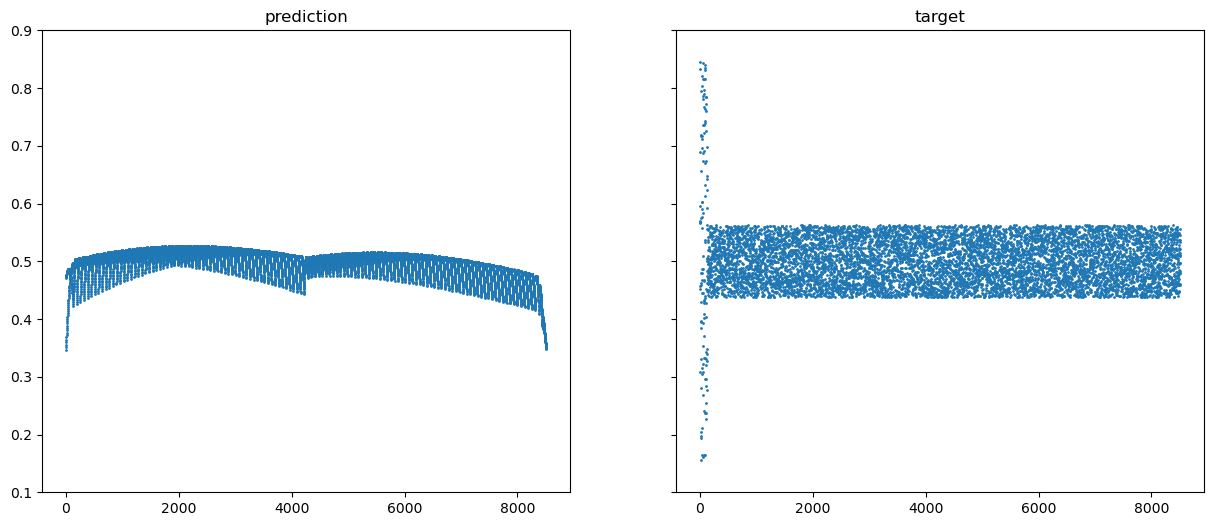

In [17]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize = (15, 6))
ax[0].set_ylim([0.1, 0.9])
x_values = np.arange(len(prediction.cpu().numpy()))

ax[0].scatter(x_values, prediction.cpu().numpy(), marker='o', s=1)
ax[0].set_title("prediction")
ax[1].scatter(x_values, all_pixel_values.cpu().numpy(), marker='o', s=1)
ax[1].set_title("target")

In [21]:
prediction.mul_(2).sub_(1)
index_tracker = 0
cppn1 = CPPN1()
with torch.no_grad():
    for name, param in cppn1.named_parameters():
        # print(name)
        if name.endswith(".weight"):
            # print(param) 
            temp_tensor = prediction[index_tracker:(index_tracker + param.numel())]
            print(param.numel())
            temp_tensor = torch.reshape(temp_tensor, param.shape)
            print(temp_tensor)
            param.data.copy_(temp_tensor)
            # print(param.numel())
            index_tracker += param.numel()
    
            print(f"{name} replacement complete")

    torch.save(cppn1.state_dict(), "Checkpoints/CPPNsquared_output.pt")

128
tensor([[-1.6139, -1.1182],
        [-1.5960, -1.1123],
        [-1.5783, -1.1068],
        [-1.5608, -1.1016],
        [-1.5436, -1.0966],
        [-1.5267, -1.0919],
        [-1.5099, -1.0875],
        [-1.4934, -1.0834],
        [-1.4772, -1.0796],
        [-1.4612, -1.0761],
        [-1.4455, -1.0728],
        [-1.4300, -1.0699],
        [-1.4148, -1.0672],
        [-1.3999, -1.0648],
        [-1.3852, -1.0627],
        [-1.3708, -1.0608],
        [-1.3566, -1.0593],
        [-1.3428, -1.0580],
        [-1.3291, -1.0570],
        [-1.3158, -1.0562],
        [-1.3027, -1.0558],
        [-1.2899, -1.0556],
        [-1.2774, -1.0556],
        [-1.2652, -1.0560],
        [-1.2532, -1.0566],
        [-1.2416, -1.0574],
        [-1.2302, -1.0586],
        [-1.2191, -1.0600],
        [-1.2082, -1.0616],
        [-1.1977, -1.0635],
        [-1.1875, -1.0657],
        [-1.1775, -1.0681],
        [-1.1678, -1.0708],
        [-1.1584, -1.0737],
        [-1.1493, -1.0768],
        [-1.1405